# Classificação com MLP
Classificação de Imagens de acordo com dados de CIFAR10
Classes : ['Avião', 'Automóvel','Passáro','Gato','Cervo','Cachorro', 'Sapo', 'Cavalo', 'Navio', 'Caminhão']

O Uso do MLP para classificar, isso pois MLPs não têm conhecimento prévio da estrutura espacial das imagens. Além disso, imagens geralmente têm uma alta dimensionalidade de entrada, o que pode levar a uma grande quantidade de parâmetros em um MLP. Isso torna o treinamento de MLPs em imagens muito mais demorado e propenso a overfitting.

In [2]:
# Importando Bibliotecas
import os
import torch
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10

In [3]:
# Variveis Globais
DATA_DIR = './'
CATEGORIES = ['Avião', 'Automóvel','Passáro','Gato','Cervo','Cachorro', 'Sapo', 'Cavalo', 'Navio', 'Caminhão']

In [4]:
# Dados 
cifar10_train = CIFAR10(DATA_DIR, train=True, download=True)
cifar10_test = CIFAR10(DATA_DIR, train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# Quantidade de dados para treinamento e teste
(len(cifar10_train), len(cifar10_test))

(50000, 10000)

In [6]:
import torchvision.transforms as tt
prep_transform = tt.Compose([tt.ToTensor(), tt.Normalize(
    (0.4914, 0.4822, 0.4465),
    (0.2470, 0.2435, 0.2616)
)])
tensor_train = CIFAR10(DATA_DIR, train=True, download=False, transform=prep_transform)
tensor_test = CIFAR10(DATA_DIR, train=False, download=False, transform=prep_transform)


In [7]:
imgs = torch.stack([img_t for img_t, _ in tensor_train], dim=3)
imgs.shape

torch.Size([3, 32, 32, 50000])

In [8]:
imgs.view(3, -1).mean(dim=1) # Média das Cores

tensor([-1.2762e-06, -1.7074e-04,  1.1819e-04])

In [9]:
imgs.view(3, -1).std(dim=1) # Desvio Padrão das Cores

tensor([1.0001, 0.9999, 1.0000])

In [10]:
from torch.utils.data import DataLoader
batch_size = 64

train_loader = DataLoader(tensor_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(tensor_test, batch_size=batch_size, shuffle=True)

In [11]:
# Testando o MLP para classificar imagem

from torch import nn

class MLPClassifier(nn.Module) :
    def __init__(self) :
        super().__init__()

        self.flatten = nn.Flatten()

        self.layers = nn.Sequential(
            nn.Linear(32 * 32 * 3, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x) :
        v = self.flatten(x)
        return self.layers(v)

In [1]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Rodando na {device}')

NameError: name 'torch' is not defined

In [13]:
model = MLPClassifier().to(device)

In [14]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
lossfunc = nn.CrossEntropyLoss() 

In [15]:
def train(model, dataloader, lossfunc, optimizer) :
    model.train()
    cumloss = 0.0
    for imgs, labels in dataloader :
        imgs, labels = imgs.to(device), labels.to(device)
        pred = model(imgs)
        loss = lossfunc(pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return cumloss / len(dataloader)

def validate(model, dataloader, loss_func) : 
    model.eval()
    cumloss = 0.0
    with torch.no_grad() : 
        for imgs, labels in dataloader : 
            imgs, labels = imgs.to(device), labels.to(device)
            pred = model(imgs)
            loss = loss_func(pred, labels)
            cumloss += loss.item()
        return cumloss / len(dataloader)

In [16]:
def plot_losses(losses):
    fig = plt.figure(figsize=(13, 5))
    ax = fig.gca()
    for loss_name, loss_values in losses.items():  
        ax.plot(loss_values, label=loss_name)
    ax.legend(fontsize="16")
    ax.set_xlabel("Iteração", fontsize="16")
    ax.set_ylabel("Perda", fontsize="16")
    ax.set_title("Perdas vs Iterações", fontsize="16")

In [17]:
epochs = 31
train_losses = []
test_losses = []
for t in range(epochs) :
    train_loss = train(model, train_loader, lossfunc, optimizer)
    train_losses.append(train_loss)
    if(t % 10 == 0) :
        print(f"[{(t+1)} Treinado]")
    test_loss = validate(model, test_loader, lossfunc)
    test_losses.append(test_loss)

[1 Treinado]


KeyboardInterrupt: 

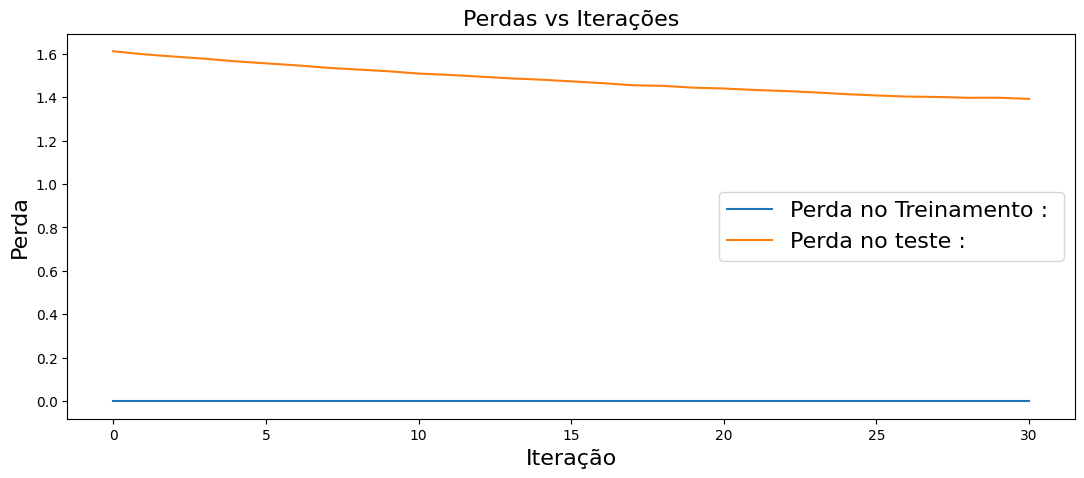

In [ ]:
losses = {"Perda no Treinamento : " :  train_losses, "Perda no teste : " : test_losses}
plot_losses(losses)

In [18]:
class ConvolutionalModel(nn.Module) :
    def __init__(self) : 
        super().__init__() 
        self.convlayers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=(3,3)),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(16, 32, kernel_size=(3,3)),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )

        self.linearlayers = nn.Sequential(
            nn.Linear(1152, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )
    
    def forward(self, x) :
        x = self.convlayers(x)
        x = torch.flatten(x, 1)
        return self.linearlayers(x)

In [19]:
convmodel = ConvolutionalModel().to(device)

In [20]:
conv_optimizer = torch.optim.SGD(convmodel.parameters(), lr=0.001)
convlossfunc = nn.CrossEntropyLoss()

In [65]:
epochs = 51
train_losses = []
test_losses = []
for t in range(epochs) :
    train_loss = train(convmodel, train_loader, convlossfunc, conv_optimizer)
    train_losses.append(train_loss)
    if(t % 10 == 0) :
        print(f"[{(t+1)} Treinado]")
    test_loss = validate(convmodel, test_loader, convlossfunc)
    test_losses.append(test_loss)

[1 Treinado]
[11 Treinado]
[21 Treinado]
[31 Treinado]
[41 Treinado]
[51 Treinado]


In [73]:
# Testando em imgs próprias
import sysconfig
from PIL import Image
img = Image.open('./Fusca.jpg')



In [74]:
prep_transforms = tt.Compose([
    tt.Resize((32,32)),
    tt.ToTensor(),
    tt.Normalize(
    (0.4914, 0.4822, 0.4465),
    (0.2470, 0.2435, 0.2616))
    
])

img_tensor = prep_transforms(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


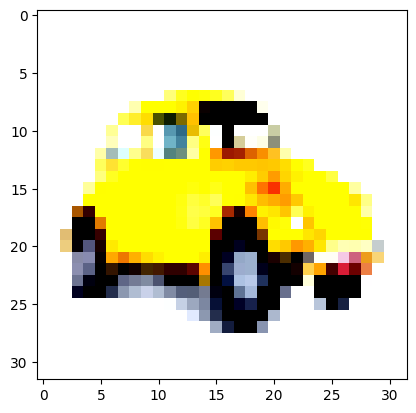

In [75]:
plt.imshow(img_tensor.permute(1,2, 0))

In [76]:
batch = img_tensor.unsqueeze(0).to(device)

In [78]:
import operator
output = convmodel(batch)
logits = torch.nn.functional.softmax(output, dim=1) * 100
prob_dict = {}

for i, classname in enumerate(CATEGORIES):
  prob = logits[0][i].item()
  prob_dict[classname] = [prob]

result = max(prob_dict.items(), key=operator.itemgetter(1))
result

('Sapo', [54.4311408996582])